In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import nltk
import random
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.model_selection import cross_val_score
from sklearn import model_selection
from nltk.stem import PorterStemmer, LancasterStemmer
from nltk.tokenize import sent_tokenize, word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer,TfidfTransformer
from xgboost import XGBClassifier
from xgboost import plot_importance
import xgboost as xgb
from matplotlib import pyplot
from sklearn.calibration import CalibratedClassifierCV
import lightgbm as lgb
import datetime 


In [3]:
train = pd.read_csv('data/training_variants')
trainingText = pd.read_csv('data/training_text', sep="\|\|", engine='python', header=None, names=["ID","Text"], skiprows=1)

test = pd.read_csv('data/test_variants')
testText = pd.read_csv('data/test_text', sep="\|\|", engine='python', header=None, names=["ID","Text"], skiprows=1)
pid = test['ID'].values

train = train.merge(trainingText, on='ID', how='left')
test = test.merge(testText, on='ID', how='left')

In [4]:
stop_words = set(stopwords.words('english'))

def getTerms(sentences):
    tokens = nltk.word_tokenize(sentences)
    words = " ".join([w.lower() for w in tokens if not w.lower()  in stop_words and  w.isalnum()])

    return words
trainingText['PText'] = trainingText['Text'].apply(getTerms)
testText['PText'] = testText['Text'].apply(getTerms)

In [29]:
trainingText.columns
countVect = CountVectorizer()
wordCountPerDoc = countVect.fit_transform(trainingText['PText'])
wordCountPerDoc

tTransformer = TfidfTransformer(smooth_idf=False)
tfidf = tTransformer.fit_transform(wordCountPerDoc)
tfidf = tfidf.toarray()
print(wordCountPerDoc.shape)
print(tfidf.shape)
train['PText'] = trainingText['PText']
test['PText'] = testText['PText']

(3321, 125627)
(3321, 125627)


In [7]:
def magicFrequency(countVect, tfidf, wordCountPerDoc) : 
    su = wordCountPerDoc.sum(axis=0).tolist()[0]
    sutf = tfidf.sum(axis=0).tolist()
    
    mostFrequentWords = [(word, su[idx], sutf[idx]) for word, idx in countVect.vocabulary_.items()]
    mostFrequentWords = sorted(mostFrequentWords, key=lambda x : -x[1])
    mostFrequentWordsTF = sorted(mostFrequentWords, key=lambda x : -x[2])
    
    return (mostFrequentWords,mostFrequentWordsTF)

_, x = magicFrequency(countVect, tfidf, wordCountPerDoc)

x[:50]

[('mutations', 236727, 278.13197717049724),
 ('cells', 183587, 179.98823225068497),
 ('brca1', 53862, 171.32882933779436),
 ('variants', 65651, 136.32395733499496),
 ('fig', 100215, 130.84644224496046),
 ('et', 104558, 125.91538982307723),
 ('mutation', 102320, 121.00571142289769),
 ('cell', 113602, 114.3199881364006),
 ('figure', 97049, 109.04086350298445),
 ('cancer', 90589, 107.19948147838632),
 ('pten', 28524, 100.43479988330171),
 ('patients', 85595, 97.7626262566456),
 ('egfr', 46491, 93.73195875634964),
 ('activity', 75859, 89.86834103583409),
 ('protein', 79011, 85.98298384646772),
 ('kinase', 60257, 85.66607312213725),
 ('p53', 34296, 83.0608504884691),
 ('mutant', 67081, 79.25517082606873),
 ('mutants', 52966, 76.95650973176471),
 ('domain', 63014, 75.9609070247806),
 ('expression', 75308, 72.98765732425517),
 ('tumor', 61966, 72.84319413773588),
 ('using', 63489, 69.48294958657353),
 ('data', 59915, 68.79461793904291),
 ('also', 66345, 68.19023341816522),
 ('tumors', 52407, 

In [8]:
vectorizers = {}
transformers = {}
tfidfs = {}
wordCounts = {}
for c in train['Class'].unique():
    print(c)
    vectorizers[c] = CountVectorizer()
    wordCounts[c] = vectorizers[c].fit_transform(train[train['Class']==c]['PText'])
    
    transformers[c] = TfidfTransformer(smooth_idf=False)
    tfidfs[c] = transformers[c].fit_transform(wordCounts[c])
    tfidfs[c] = tfidfs[c].toarray()

1
2
3
4
5
6
7
8
9


In [9]:
mostPopularWords = {}

for c in train['Class'].unique():
    _, xx = magicFrequency(vectorizers[c], tfidfs[c],wordCounts[c])
    mostPopularWords[c] = [x[0] for x in xx]
    

In [10]:
def frequentWordsByText(text) :
    cleanText = getTerms(text)
    countVect = CountVectorizer()
    wordCountPerDoc = countVect.fit_transform([cleanText])
    
    mostFrequentWords = [(word, wordCountPerDoc[0,idx]) for word, idx in countVect.vocabulary_.items()]

    mostFrequentWords = sorted(mostFrequentWords, key=lambda x : -x[1])

    return mostFrequentWords

frequentWordsByText(train['PText'][5])


[('mutations', 150),
 ('cbl', 121),
 ('binding', 63),
 ('cancer', 62),
 ('stability', 40),
 ('effects', 33),
 ('fig', 32),
 ('protein', 30),
 ('activity', 30),
 ('table', 27),
 ('cells', 26),
 ('state', 26),
 ('states', 25),
 ('proteins', 22),
 ('egfr', 22),
 ('energy', 21),
 ('damaging', 21),
 ('methods', 20),
 ('changes', 19),
 ('cell', 18),
 ('ubiquitination', 18),
 ('random', 18),
 ('mutant', 18),
 ('mutation', 17),
 ('mutants', 16),
 ('structures', 16),
 ('figure', 16),
 ('activation', 16),
 ('found', 15),
 ('e2', 14),
 ('active', 14),
 ('densitometry', 14),
 ('ncbl', 14),
 ('experimental', 14),
 ('compared', 14),
 ('using', 14),
 ('data', 13),
 ('e3', 13),
 ('different', 13),
 ('driver', 13),
 ('affinity', 13),
 ('experimentally', 13),
 ('according', 12),
 ('computational', 12),
 ('four', 12),
 ('hela', 11),
 ('free', 11),
 ('one', 11),
 ('destabilizing', 11),
 ('10', 11),
 ('a549', 11),
 ('cycle', 11),
 ('models', 11),
 ('substrate', 10),
 ('single', 10),
 ('highly', 10),
 ('tes

In [11]:
train['fw'] = train['PText'].apply(lambda x : [wordTuple[0] for wordTuple in frequentWordsByText(x)])
train['fw'].head(5)

0    [cyclin, cdk10, fig, ets2, cells, expression, ...
1    [mutations, lung, cell, mutation, egfr, cells,...
2    [mutations, lung, cell, mutation, egfr, cells,...
3    [cbl, mutations, cases, aupd, upn, figure, mut...
4    [mutations, cbl, binding, cancer, stability, e...
Name: fw, dtype: object

In [40]:
test['fw'] = test['PText'].apply(lambda x : [wordTuple[0] for wordTuple in frequentWordsByText(x)])

In [49]:
nboverlap = 250

def overlapRange(fw, c, overlapSize):
    n = len(list(set(fw[:overlapSize]) & set(mostPopularWords[c][:overlapSize])))
    return float(n)/overlapSize
    

for i in range(1, 10):
    columnName = 'overlap' + str(nboverlap) + 'C'+str(i)
    train[columnName] = train['fw'].apply(lambda x: overlapRange(x, i, nboverlap))
    test[columnName] = test['fw'].apply(lambda x: overlapRange(x, i, nboverlap))
    print(columnName)


overlap250C1
overlap250C2
overlap250C3
overlap250C4
overlap250C5
overlap250C6
overlap250C7
overlap250C8
overlap250C9


In [51]:
geneDummies = pd.get_dummies(train['Gene'])

features=['overlap250C'+str(c) for c in range(1, 10)]
# features.extend(geneDummies.columns)

trainWithGenes = train.join(geneDummies)

In [52]:
def gboost1(df, features):
    print('\n##################\nXGBoost\n##################')
    param = {}
    # param['booster'] = 'gbtree'
    #param['objective'] = 'binary:logistic'
    # param["eval_metric"] = "error"
    # param['eta'] = 0.3
    # param['gamma'] = 0
    param['max_depth'] = 6
    param['n_estimators'] = 200
    param['learning_rate'] = 0.1
    # param['min_child_weight'] = 1
    # param['max_delta_step'] = 0
    # param['subsample'] = 1
    # param['colsample_bytree'] = 1
    # param['silent'] = 1
    # param['seed'] = 0
    # param['base_score'] = 0.4

    estimator = XGBClassifier()
    estimator.set_params(**param)
    x1, x2, y1, y2 = model_selection.train_test_split(df[features], df['Class'], test_size=0.2)
    calibratedCV = CalibratedClassifierCV(estimator, method='sigmoid', cv=5)
    calibratedCV.fit(x1, y1)
    prediction = calibratedCV.predict(x2)
    
#     print(calibratedCV.best_estimator_.booster())
#     print(calibratedCV.calibrated_classifiers_)
#     for c in calibratedCV.calibrated_classifiers_:
#         print(c.feature_importances_)
#         plot_importance(c)
#         pyplot.show()
#     feat_imp = pd.Series(calibratedCV.booster().get_fscore()).sort_values(ascending=False)
#     feat_imp.plot(kind='bar', title = 'Feature imp')
#     estimator.fit(x1, y1)
#     prediction = estimator.predict(x2)
#     xgb.plot_importance(estimator, max_num_features = 50)
#     imp = estimator.feature_importances_
#     plot_importance(estimator)
#     pyplot.show()

    print('accuracy %s %s' % (np.mean(prediction == y2), prediction[:5]))
    result = calibratedCV.predict(test[features])
#     result = estimator.predict(test)
#     return (imp, result)
    return result

prediction = gboost1(train, features)
#gboost1(train, features)


##################
XGBoost
##################
accuracy 0.604511278195 [5 2 7 6 7]


In [50]:
test.columns

Index(['ID', 'Gene', 'Variation', 'Text', 'PText', 'fw', 'overlap250C1',
       'overlap250C2', 'overlap250C3', 'overlap250C4', 'overlap250C5',
       'overlap250C6', 'overlap250C7', 'overlap250C8', 'overlap250C9'],
      dtype='object')

In [55]:
def submission(prediction):
    onehot = pd.get_dummies(prediction)
    submission = pd.DataFrame()
    submission['ID'] = test['ID']
    submission = submission.join(onehot)
    submission.columns = ['ID', 'class1','class2','class3','class4','class5','class6','class7','class8','class9']
    now = datetime.datetime.now()
    date_string = now.strftime('%Y-%m-%d-%I-%M')
    submission.to_csv('output/' date_string + 'submission_xgb.csv', index=False)
submission(prediction)

SyntaxError: invalid syntax (<ipython-input-55-ba02ca48aa95>, line 9)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  


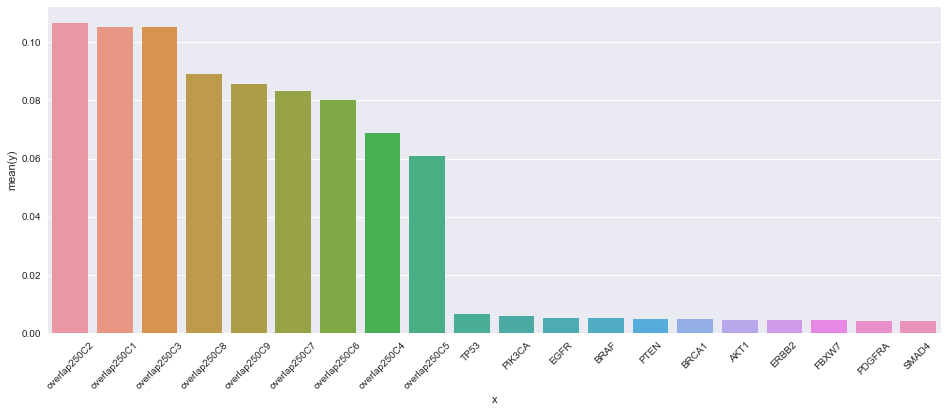

In [22]:
xgboostImp.shape
len(features)
xgboostFeatureImp = pd.DataFrame()
xgboostFeatureImp['x'] = features
xgboostFeatureImp['y'] = xgboostImp
xgboostFeatureImp = xgboostFeatureImp.sort(['y'], ascending = 0)
plt.figure(figsize = (16, 6))
plt.xticks(rotation=45)
sns.barplot(x = 'x', y ='y', data = xgboostFeatureImp[:20])
plt.show()
plt.figure(figsize = (16, 6))
plt.xticks(rotation=90)
sns.barplot(x = 'x', y ='y', data = xgboostFeatureImp[-140:])


In [24]:
len(features)

273